In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as stat
import networkx as nx
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from glob import glob

In [2]:
# meta data includes the course title, run dates
AM_meta = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-meta.csv')
AM_meta

,id,metadata.display_name,category,metadata.start,metadata.end,metadata.enrollment_start,metadata.enrollment_end
0,MITxPRO+AMxB+1T2018,Additive Manufacturing for Innovative Design a...,course,2018-04-30 04:00:00,2018-07-02 23:30:00,2018-03-06,2018-05-11 23:30:00


In [3]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')
AM_modules[:5]

,id,mod_hex_id,courseID,mod_type,name,markdown,order,childOrder,treelevel,chpModPar,seqModPar,vrtModPar,parent,modparent_childlevel
0,block-v1:MITxPRO+AMxB+1T2018+type@course+block...,course,MITxPRO+AMxB+1T2018,course,Additive Manufacturing for Innovative Design a...,NaN,1,0,0,NaN,NaN,NaN,course,course/0
1,block-v1:MITxPRO+AMxB+1T2018+type@chapter+bloc...,b9dd2cb6d3a44e96aedb515388e02405,MITxPRO+AMxB+1T2018,chapter,"Entrance Survey (5 min, required)",NaN,2,1,1,b9dd2cb6d3a44e96aedb515388e02405,NaN,NaN,course,course/1
2,block-v1:MITxPRO+AMxB+1T2018+type@sequential+b...,5589ca87f02147ec8452cead30cc4d5f,MITxPRO+AMxB+1T2018,sequential,"Entrance Survey (5 min, required)",NaN,3,1,2,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,NaN,b9dd2cb6d3a44e96aedb515388e02405,b9dd2cb6d3a44e96aedb515388e02405/1
3,block-v1:MITxPRO+AMxB+1T2018+type@vertical+blo...,57c4192d1f714350848b1424ce840c75,MITxPRO+AMxB+1T2018,vertical,Entrance Survey,NaN,4,1,3,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,5589ca87f02147ec8452cead30cc4d5f,5589ca87f02147ec8452cead30cc4d5f/1
4,block-v1:MITxPRO+AMxB+1T2018+type@html+block@4...,401ee1f6f3684be7b6124490f34adc5a,MITxPRO+AMxB+1T2018,html,NaN,NaN,5,1,4,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,57c4192d1f714350848b1424ce840c75,57c4192d1f714350848b1424ce840c75/1


In [4]:
# session level edge data
AM_edges_sessionLevel01 = pd.read_csv('data/MITxPRO+AMxB+1T2018/edges/MITxPRO+AMxB+1T2018-stdAgg-edgeList-sessionLevel-1.csv')
#AM_edges_sessionLevel01[AM_edges_sessionLevel01['user_id'] == 15779327][100:150]

user_id
50251       [0, 1, 2, 1, 4, 5, 4, 2, 4, 5, 2, 5, 6, 8, 6, ...
133668                                [0, 457, 2, 4, 5, 4, 0]
1893018     [0, 1, 2, 4, 5, 4, 6, 5, 6, 8, 9, 10, 11, 21, ...
4396150     [0, 1, 2, 1, 4, 5, 2, 5, 4, 6, 5, 6, 8, 9, 10,...
4637137     [0, 1, 2, 1, 4, 5, 6, 8, 9, 10, 11, 21, 28, 30...
5315643     [0, 6, 8, 1, 2, 4, 5, 6, 8, 9, 10, 11, 10, 21,...
5597733     [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 21, 28, 30, 6...
5603337     [0, 1, 2, 4, 5, 6, 8, 9, 10, 9, 11, 10, 21, 28...
5610165     [0, 1, 2, 1, 4, 5, 6, 8, 9, 10, 11, 10, 12, 21...
6258725     [0, 1, 2, 4, 5, 4, 5, 6, 128, 129, 128, 130, 1...
6536839     [0, 1, 2, 1, 4, 5, 6, 8, 9, 10, 11, 10, 21, 28...
7542749     [0, 1, 2, 4, 5, 6, 8, 6, 9, 10, 11, 8, 11, 21,...
7958154     [0, 1, 2, 1, 4, 5, 2, 5, 6, 8, 9, 10, 11, 21, ...
10226345    [0, 1, 2, 4, 5, 6, 5, 6, 8, 9, 10, 9, 11, 10, ...
11375718    [0, 1, 2, 4, 5, 4, 6, 5, 6, 8, 9, 10, 11, 10, ...
11376224    [0, 1, 2, 1, 4, 5, 6, 8, 9, 10, 11, 21, 28, 30...


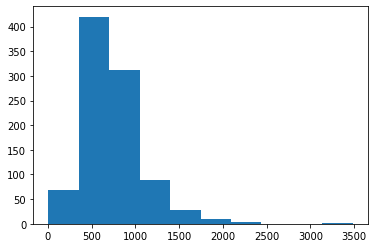

In [5]:
# for each student this is list of numerical id's for the URLs - removing duplicates
def get_trajectory(df):
    order = [0]
    for url in df['order']:
        if url != order[-1]:
            order.append(url)
    order.append(0)
    return order

trajectories = []

for fname in glob('data/MITxPRO+AMxB+1T2018/edges/*.csv'):
    df = pd.read_csv(fname)
    trajectories.append(df)
    
trajectories = pd.concat(trajectories)
trajectories = trajectories.groupby('user_id').apply(get_trajectory)
traj_lengths = trajectories.map(len).values

plt.hist(traj_lengths)
max(traj_lengths)
trajectories[:25]

In [6]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y
            
def valid_generator():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y

In [7]:
hidden_dim = 30
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.001)

input_ = Input(shape=(None,))
embed = Embedding(number_of_URL, embedding_dim)(input_)

rnn = LSTM(hidden_dim, return_sequences=True)(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax')(rnn)

model = Model(inputs=input_, outputs=predicted_URL)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 30)          33630     
_________________________________________________________________
lstm (LSTM)                  (None, None, 30)          7320      
_________________________________________________________________
dense (Dense)                (None, None, 1121)        34751     
Total params: 75,701
Trainable params: 75,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights('weights_version01.h5')
model.fit_generator(train_generator(), 
                    validation_data=valid_generator(),
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=10,
                    verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 800 steps, validate for 130 steps
Epoch 1/10
800/800 [==============================] - 445s 556ms/step - loss: 1.6530 - acc: 0.5960 - val_loss: 1.7414 - val_acc: 0.5783
Epoch 2/10
449/800 [===============>..............] - ETA: 3:03 - loss: 1.6333 - acc: 0.6002

In [ ]:
# user list key - session level
AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
AM_userList

In [5]:
# learning pathway network edge lists - edge list for each student in the course that represent a directed 
# transitions networks  of students pathway through the courses content modules.  this is all students.
AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
AM_edgelist[:5]

,source,target,stds,weight_c,dis,sl
0,00c23be7a0584af395428ab3a704e552,0e3c2d8cac1e44af8bd7fabc48f8d079,8,8,1,0
1,00c23be7a0584af395428ab3a704e552,1f5002403e13485da7e7b1f5896e81ee,3,4,-5,0
2,00c23be7a0584af395428ab3a704e552,9af4973779c443ac986aa5b2a63462d6,3,4,-1,0
3,00c23be7a0584af395428ab3a704e552,aedac84ad12f487db1c88dbe3c82abde,1,1,-18,0
4,00c23be7a0584af395428ab3a704e552,c8a31966713e4ef18f4f06cd4a79d374,1,1,2,0


In [6]:
G = nx.DiGraph()
edges = [x[1].values for x in AM_edgelist.iloc[:,:3].iterrows() if x[1][2] > 20]
G.add_weighted_edges_from(edges)

In [7]:
#pos=nx.kamada_kawai_layout(G)
# plt.figure(figsize=(12,12))
# nx.draw(G, node_size=10)
# plt.show()

In [8]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

,id,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,401ee1f6f3684be7b6124490f34adc5a,MITxPRO+AMxB+1T2018,html,1,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,907,2300
1,27bf430c96cb4d8da7368c4697de187b,MITxPRO+AMxB+1T2018,html,2,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,922,1853
2,0fec97a46b71456d9d9037e5edac7bb0,MITxPRO+AMxB+1T2018,html,3,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,26,29
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,MITxPRO+AMxB+1T2018,problem,4,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,9546e9f7f20c4bf2b09c7c839fd67571,930,5195
4,04d85100616943f8a3d2b084f403ba5f,MITxPRO+AMxB+1T2018,html,5,3e2b8f40ac004d56a2e85e503e0e635b,b4100fe285a442a2ba6de2e94b28642b,6fddc8e62a094b818e30327c45ebf7f3,928,2750
...,...,...,...,...,...,...,...,...,...
750,5b42266d225e4a83bcf7833af7143417,MITxPRO+AMxB+1T2018,html,751,476998cc999c4312b392d128c14cab9b,2c093467e9d54014a0d4f00f7abf931c,71d13483bea1443e83f02d4b036c404e,560,1739
751,253c3d95e42f47a192997f25c3fd5881,MITxPRO+AMxB+1T2018,html,752,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,cc2f936f1afc4df0bb4bf7fa943b1d97,788,2567
752,7d262be6d9b74836b47447db1b70289d,MITxPRO+AMxB+1T2018,problem,753,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,c3e12647605f4894ab69df903b567bf2,774,4682
753,024fed17849e4d60bfc86afa47ce9cb4,MITxPRO+AMxB+1T2018,html,754,4022bcb994a3447a9c609f4ce5bd9016,9852b66b25d14ec0b379bc6532e1753c,e4cd156124f04c1ab2c7fbeead3afa35,0,0


In [11]:
#model.save_weights('weights_version01.h5')

In [9]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chpModLabel,seqModLabel,In-Degree,Out-Degree,Degree
0,401ee1f6f3684be7b6124490f34adc5a,1594.1262f,1048.7539f,MITxPRO+AMxB+1T2018,html,1,907,2300,"Entrance Survey (5 min, required)",Entrance Survey-Html,16,14,30
1,27bf430c96cb4d8da7368c4697de187b,1580.7435f,1018.63403f,MITxPRO+AMxB+1T2018,html,2,922,1853,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,10,8,18
2,0fec97a46b71456d9d9037e5edac7bb0,1598.8334f,1135.2795f,MITxPRO+AMxB+1T2018,html,3,26,29,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,2,2,4
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,1549.503f,1036.6296f,MITxPRO+AMxB+1T2018,problem,4,930,5195,"Pre-Assessment (10 min, required)",Pre-Assessment Completion Confirmation,5,7,12
4,04d85100616943f8a3d2b084f403ba5f,1505.2043f,1015.3352f,MITxPRO+AMxB+1T2018,html,5,928,2750,Get Started (25 min),Welcome-Html,19,14,33


In [10]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance[:5]

,id,percent_grade,date_joined,enroll_created_date,cert_status,certGrp
0,14172563,0.65,3/24/2017 14:25,3/8/2018 17:31,Pass,Not certified (> 70% Grade)
1,18373780,0.79,3/8/2018 17:49,3/8/2018 17:49,Pass,Certified (< 70% Grade)
2,15779327,0.80,8/28/2017 20:48,3/8/2018 18:07,Pass,Certified (< 70% Grade)
3,18373985,0.91,3/8/2018 18:08,3/8/2018 18:08,Pass,Certified (< 70% Grade)
4,18374076,0.16,3/8/2018 18:15,3/8/2018 18:15,NaN,Not certified (> 70% Grade)


In [11]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

,id,metadata.display_name,category,metadata.start,metadata.end
0,MITxPRO+LASERxB1+1T2019,"Strategy, Products, Capability Work, and Teams",course,2019-03-09 01:00:00,2019-04-09 23:59:00


In [12]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

# LaaL_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [13]:
LaaL_edelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

,from,to,stds,weight,dis,sl
0,001339db8ced4cf78829ebe8b145449d,001339db8ced4cf78829ebe8b145449d,179,1096,0,1
1,001339db8ced4cf78829ebe8b145449d,452745e0366e42ae81561bfddebcc6c3,177,179,1,0
2,001339db8ced4cf78829ebe8b145449d,4660ff2089114e8db82ceb26a4f329e3,2,2,2,0
3,001339db8ced4cf78829ebe8b145449d,901e92500aea43c79f19f1b279050668,4,4,-1,0
4,00ae5f0c51874a73a41ebea838d95682,00ae5f0c51874a73a41ebea838d95682,119,383,0,1


In [14]:
LaaL_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

,name,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,b613861cecf84ffcab01afb23f660475,MITxPRO+LASERxB1+1T2019,problem,1,41ad78dff2594088a4eb8b6b7ce406f3,c1b52a1ef69a404ea9132e95ad25093a,4aea5151404640ac8ebe81deff85def0,241,1610
1,e2911e79efc2420eac45d9f671463d4b,MITxPRO+LASERxB1+1T2019,problem,2,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,1686
2,519d1b8c59404d67b54e96c5c8a830b2,MITxPRO+LASERxB1+1T2019,problem,3,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,592
3,531db53f81f646edb0cdcfe0085b03b7,MITxPRO+LASERxB1+1T2019,problem,4,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,566
4,4f5f94b2f95141e0a9d53a61da2276da,MITxPRO+LASERxB1+1T2019,problem,5,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,571


In [15]:
LaaL_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chapterModLabel,In-Degree,Out-Degree,Degree
0,b613861cecf84ffcab01afb23f660475,-882.02423f,2054.1257f,MITxPRO+LASERxB1+1T2019,problem,1,241,1610,Week 0: Get Started (40 min),22,23,45
1,e2911e79efc2420eac45d9f671463d4b,-758.68823f,2250.8474f,MITxPRO+LASERxB1+1T2019,problem,2,241,1686,Week 0: Get Started (40 min),23,21,44
2,519d1b8c59404d67b54e96c5c8a830b2,-902.5562f,2516.3157f,MITxPRO+LASERxB1+1T2019,problem,3,241,592,Week 0: Get Started (40 min),5,7,12
3,531db53f81f646edb0cdcfe0085b03b7,-943.9201f,2620.5632f,MITxPRO+LASERxB1+1T2019,problem,4,241,566,Week 0: Get Started (40 min),5,5,10
4,4f5f94b2f95141e0a9d53a61da2276da,-963.7683f,2726.7637f,MITxPRO+LASERxB1+1T2019,problem,5,241,571,Week 0: Get Started (40 min),5,8,13


In [16]:
LaaL_id_and_performance = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

,id,percent_grade,date_joined,enroll_created_date,cert_status,certGrp
0,11686401,0.38,8/23/2016 22:41,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
1,15603897,0.02,8/14/2017 13:53,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
2,11382474,0.40,7/22/2016 12:46,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
3,20757153,0.02,9/17/2018 17:15,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
4,11615808,0.34,8/16/2016 20:59,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
